In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import math

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn')

## Loading data and preprocessing

In [5]:
df_data = pd.read_pickle('/home/dazai/Documents/Processmining/Data/pickle.pkl')

In [6]:
import random
random.seed(41)
df_data = df_data[df_data['case concept:name'].isin(np.random.choice(df_data['case concept:name'].unique(), size=11000, replace=False))]

Uncomment the cell below and run it if you dont have a pickle of preprocessed data

In [7]:
# path = r"/home/dazai/Documents/Processmining/Data/"
# df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
# df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


# df_data = pd.concat([df_train, df_test])
# df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True)
# df_data['case REG_DATE'] = pd.to_datetime(df_data['case REG_DATE'])

# df_data.sort_values(by=['event time:timestamp'], inplace=True)
# df_data.reset_index(inplace=True, drop=True)

# # remove whitespace at beginning and end of column name
# df_data.columns = df_data.columns.str.strip(' ')

## Function definitions

In [8]:
import statsmodels.api as sm



def sliding_window(window_size, df):
    """transforms df_data into supervised form 
    with rolling window implementations

    Args:
        window_size (int): size of rolling window

    Returns:
        (X, Y): tuple of input and output arrays
    """

    windows = list(df.rolling(window=window_size))
    for i in windows[window_size-1:]:    
        # split into X and Y
        temp = i.to_numpy()
        temp = [item for sublist in temp for item in sublist]
        Y.append(temp.pop(-1))
        X.append(temp[1:])
    return None


def cross_validate(X, Y):
    """Creates a timesseries split and calculates 
    cross validation error fitted on a given estimator

    Args:
        X (array): input array 
        Y (array): output array
        estimator (sklearn_model): Tree based machine learning model

    Returns:
        accuracies (list): list of cross validation accuracies
    """
    output = []
    ts = TimeSeriesSplit(gap=175, max_train_size=None, n_splits=5, test_size=None)

    for train_index, test_index in ts.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        

        # mod = sm.OLS(y_train, X_train)
        # fii = mod.fit()
        
        model = linear_model.LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)
        output.append((y_test, y_pred))
        
    return output

        
    
# Remove timezone information
def remove_timezone(dt):
    return dt.replace(tzinfo=None)
 

## Encoding

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_data[['case AMOUNT_REQ']])
df_data['case AMOUNT_REQ'] = scaler.transform(df_data[['case AMOUNT_REQ']])

# Get dummy variables and encode lifecycle
df_dummies_lifecycle = pd.get_dummies(df_data['event lifecycle:transition'], prefix='Lifecycle', drop_first=True)
df_data = df_data.loc[:, df_data.columns != 'event lifecycle:transition'].copy().join(df_dummies_lifecycle)


# dummy variables encoded
df_dummies_name = pd.get_dummies(df_data['event concept:name'], prefix='Event Name', drop_first=True)
df_data.drop('event concept:name', axis=1, inplace=True)
df_data = df_data.join(df_dummies_name)

## Feature engineering (I think?)

In [10]:
# remove timezone
df_data['case REG_DATE'] = df_data['case REG_DATE'].apply(remove_timezone)

# Calculate time difference between current and next row
df_data['time_diff'] = df_data['event time:timestamp'].shift(-1);
df_data['time_diff'] = df_data['time_diff'] - df_data['event time:timestamp'] 
df_data['time_diff'] = df_data['time_diff'].dt.total_seconds();
# df_data['time_diff'] = df_data['time_diff'].round();
df_data = df_data.iloc[:-1];


df_data = df_data[df_data['time_diff']>=0]
df_data['time_diff'] = np.log(df_data['time_diff'].replace(0, np.nan))
df_data['time_diff'] = df_data['time_diff'].replace(np.nan, 0)


# Filter outliers
# df_data.loc[df_data['time_diff']>600, 'time_diff'] = 601
df_data = df_data[df_data['time_diff']<=600]

# Calculate time difference since case start
df_data['case REG_DATE'] = df_data['case REG_DATE'].apply(remove_timezone);
df_data['days_since_start'] = df_data['event time:timestamp'] - df_data['case REG_DATE'];
df_data['days_since_start'] = df_data['days_since_start'].dt.days;
df_data = df_data.iloc[:-1];

# Adding time features
df_data['day'] = df_data['event time:timestamp'].dt.day;
df_data['month'] = df_data['event time:timestamp'].dt.month;
df_data['hour'] = df_data['event time:timestamp'].dt.hour;
df_data['day_of_week'] = df_data['event time:timestamp'].dt.weekday;

# Cyclical encoding
df_data["hour"] = 2 * math.pi * df_data["hour"] / df_data["hour"].max()
df_data["hour_cos"] = np.cos(df_data["hour"])
df_data["hour_sin"] = np.sin(df_data["hour"])
df_data["day_of_week"] = 2 * math.pi * df_data["day_of_week"] / df_data["day_of_week"].max()
df_data["day_of_week_cos"] = np.cos(df_data["day_of_week"])
df_data["day_of_week_sin"] = np.sin(df_data["day_of_week"])

# drop unnecessary columns
df_data.drop(columns=['event time:timestamp', 'eventID', 'case REG_DATE',
                      'day_of_week', 'hour'], inplace=True)

# put columns in right order
cols = df_data.columns.tolist()
cols.remove('time_diff')
cols = cols + ['time_diff']
df_data = df_data[cols]




In [11]:
X = []
Y = []
df_data.groupby('case concept:name').apply(lambda x: sliding_window(3, x))
test = cross_validate(np.array(X), np.array(Y))


In [12]:
mse = np.mean([mean_squared_error(i[0], i[1]) for i in test])
r2 = np.mean([r2_score(i[0], i[1]) for i in test])
mae = np.mean([mean_absolute_error(i[0], i[1]) for i in test])
rmse = np.mean([mean_squared_error(i[0], i[1], squared=False) for i in test])
print(f'mse: {math.exp(mse)}\nr^2: {r2}\nrmse: {math.exp(rmse)}\nmae:{math.exp(mae)}')


mse: 11.657498282219034
r^2: 0.5753369275468089
rmse: 4.792767010692568
mae:2.9768907586083193


In [13]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
  

# # the independent variables set
# X = df_data.drop(['time_diff','case concept:name'], axis=1)
  
# # VIF dataframe
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
  
# # calculating VIF for each feature
# vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                           for i in range(len(X.columns))]
  
# print(vif_data)

In [14]:
y_true = pd.DataFrame(test[-1][0])
y_pred = pd.DataFrame(test[-1][1])
df_error = pd.concat([y_true, y_pred], axis=1)
df_error.columns = ['y_true', 'y_pred']
df_error.reset_index(inplace=True)
df_error['error'] = df_error['y_true'] - df_error['y_pred']


<AxesSubplot:xlabel='index', ylabel='error'>

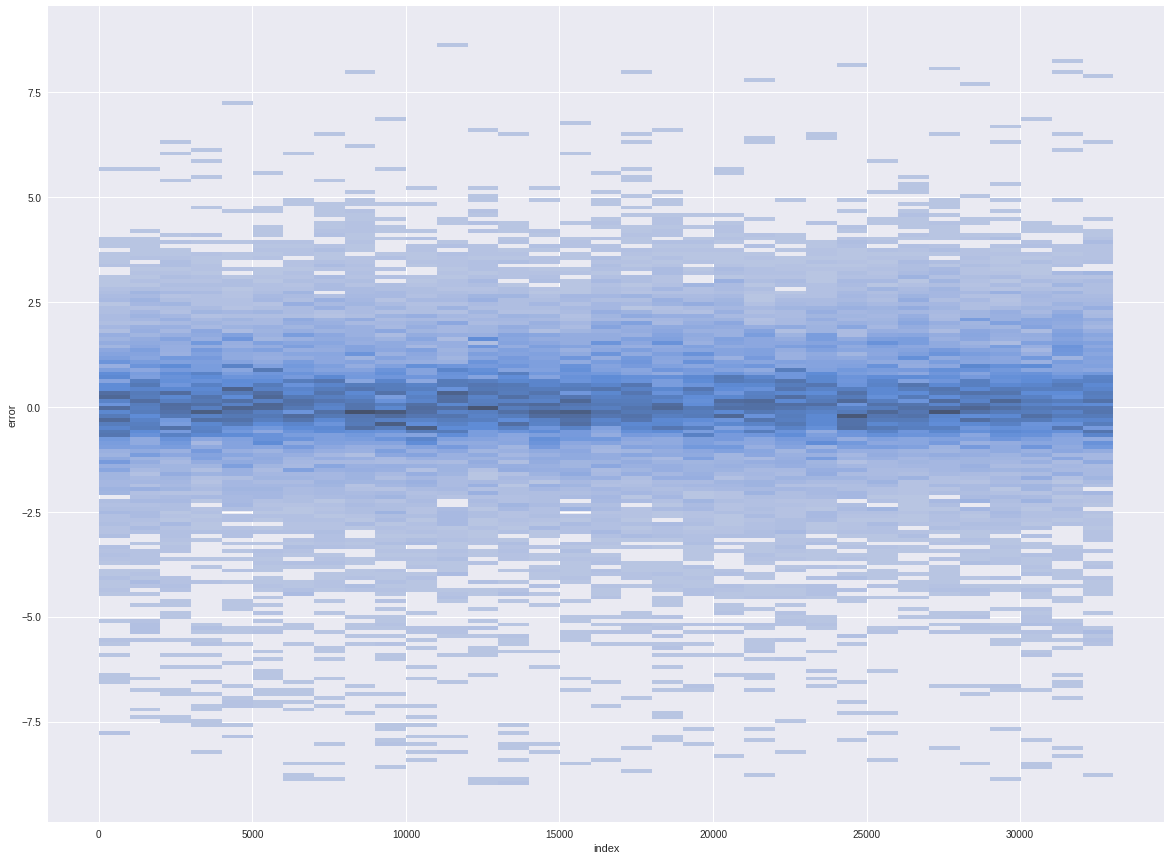

In [15]:
fig, ax = plt.subplots(figsize=(20,15))
# df_error.plot.hist(x='index', y='error', figsize=(10,5), ax=ax, bins=5)
sns.histplot(data=df_error, x='index', y='error', ax=ax)

In [35]:
df_error.iloc[:200].plot(
    kind='scatter',
    x='index', 
    y=['y_true', 'y_pred'],
    backend='plotly', 
    width=1200,
    height=800   
)

In [17]:
df_error.plot(
    kind='scatter',
    x='index', 
    y=['error'], 
    backend='plotly', 
    width=1200,
    height=800   
)

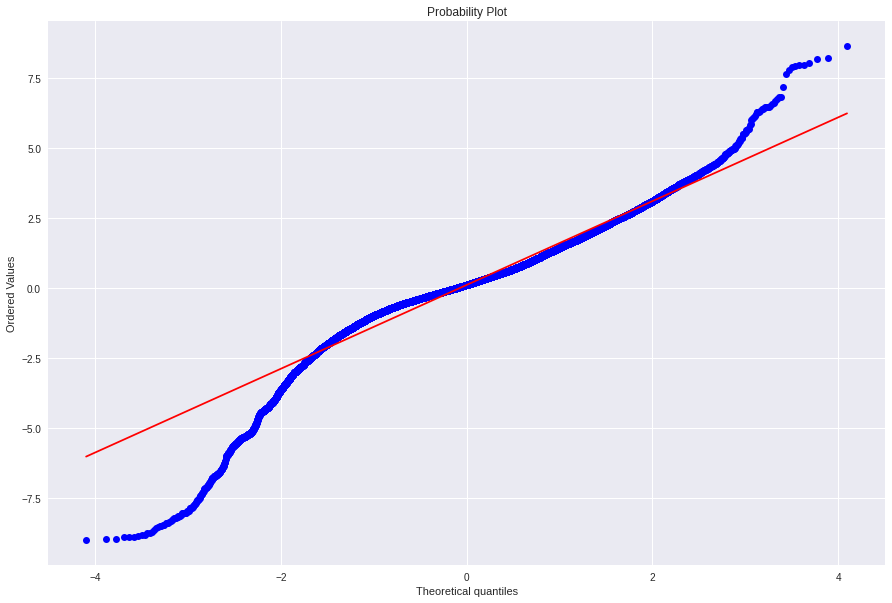

In [34]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(15,10))
stats.probplot(df_error['error'], plot=ax);

In [19]:
# fig, ax = plt.subplots(figsize=(20,15))
# df_error.plot(kind='scatter', x='index', y='y_true', color='r', ax=ax)    
# df_error.plot(kind='scatter', x='index', y='y_true', color='g', ax=ax)  
# # ax.scatter(data=df_error, x=df_error.index, y='y_true', color='r');
# # ax.scatter(data=df_error, x=df_error.index, y='y_pred', color='g');

In [20]:
# df_error.plot(kind='scatter', x='index', y='y_true', color='r', ax=ax)    
# df_error.plot(kind='scatter', x='index', y='y_true', color='g', ax=ax)    
# # df_error.plot(kind='scatter', x=df_error['index'], y='y_pred', color='r')    

In [21]:
# df_data.groupby('case concept:name').size().to_frame().describe()